In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, math, os
from scipy.interpolate import interp1d

Read in and format all data from 2022_23 master

In [2]:
# read csv files from 2022_23_master
df = pd.DataFrame()
for filename in os.listdir('2022_23_master'):
    df = pd.concat([df, pd.read_csv(f'2022_23_master/{filename}')])
# remove pitches that were not measured correctly
df.dropna(subset= ['RelHeight', 'RelSide', 'z0', 'x0', 'PlateLocHeight', 'PlateLocSide'], inplace= True)
# 0.01145833 miles is 60ft 6in
df['TimeToPlate'] = df['RelSpeed'].apply(lambda x: 0.01145833 / x * 3600)
#0.003882576 miles is 20ft 6in , needed because pfxx, pfxz are measure 40ft from plate
# df['TimeTopf'] = df['RelSpeed'].apply(lambda x: 0.003882576 / x * 3600)
#0.001988636 miles is 10ft 6in , needed because x0, z0 are measure 50ft from plate
df['TimeTo0'] = df['RelSpeed'].apply(lambda x: 0.001988636 / x * 3600)
df['vertDiff0'] = (df['z0'] - df['RelHeight']) * 12
df['horzDiff0'] = abs(-df['x0'] - df['RelSide']) * 12
df['vertDiffEnd'] = (df['PlateLocHeight'] - df['RelHeight']) * 12
df['horzDiffEnd'] = abs(df['PlateLocSide'] - df['RelSide']) * 12

In [28]:
pitcher = 'Jason Savacool'
pitcher_df = df.loc[df['Pitcher'] == pitcher]
pitch_dfs = pitcher_df.groupby('TaggedPitchType')
pitch_data = {}
for pitch in pitch_dfs:
    # pitch_data[pitch[0]] = [pitch[1]['InducedVertBreak'].mean(), pitch[1]['pfxz'].mean(), pitch[1]['HorzBreak'].mean(), pitch[1]['pfxx'].mean(), pitch[1]['TimeToPlate'].mean(), pitch[1]['TimeTopf'].mean()]
    pitch_data[pitch[0]] = [pitch[1]['vertDiffEnd'].mean(), pitch[1]['vertDiff0'].mean(), pitch[1]['horzDiffEnd'].mean(), pitch[1]['horzDiff0'].mean(), pitch[1]['TimeToPlate'].mean(), pitch[1]['TimeTo0'].mean()]

Now I can create a graph that compares each pitch's movement to see any synergy.

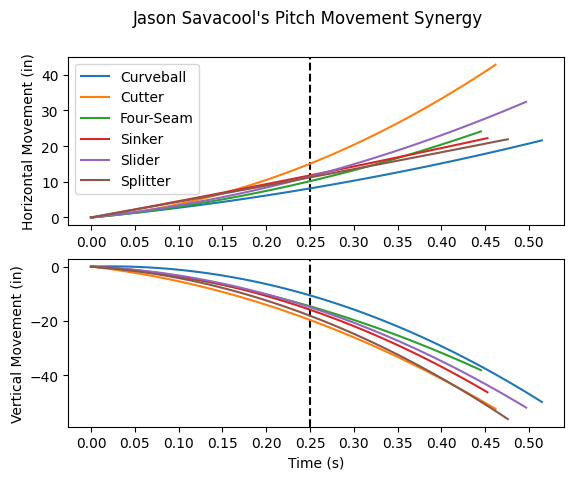

In [29]:
# create 2 subpluts, 1 for horizontal and 2 for vertical
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle(f'{pitcher}\'s Pitch Movement Synergy')
ax1.set(ylabel= 'Horizontal Movement (in)', xticks= np.arange(0,0.6,0.05))
ax1.axvline(0.25, linestyle= '--', color= 'black')
ax2.set(ylabel= 'Vertical Movement (in)', xlabel= 'Time (s)', xticks= np.arange(0,0.6,0.05))
ax2.axvline(0.25, linestyle= '--', color= 'black')
for k in pitch_data:
    # 0, the time of 20ft 6in, time of 60ft 6in
    x_vals = [0, pitch_data[k][5], pitch_data[k][4]]
    
    # 0, total horz break at 20.5ft, total horz break at 60.5ft
    # y_vals = [0, abs(pitch_data[k][2])-abs(pitch_data[k][3]), abs(pitch_data[k][2])]
    y_vals = [0, pitch_data[k][3], pitch_data[k][2]]
    
    # Generate a spline interpolation function
    f = interp1d(x_vals, y_vals, kind='quadratic')
    pitch_data[k].append(f)

    # Evaluate the spline interpolation at 100 points between min(x_vals) and max(x_vals)
    x = np.linspace(min(x_vals), max(x_vals), 100)
    y = f(x)
    ax1.plot(x, y, label= k)
    # ax1.plot(x_vals, y_vals)
    
    # 0, total vert break at 20.5ft, total vert break at 60.5ft
    # y_vals = [0, -abs(pitch_data[k][0]) + abs(pitch_data[k][1]), -abs(pitch_data[k][0])]
    y_vals = [0, pitch_data[k][1], pitch_data[k][0]]
    
    # Generate a spline interpolation function
    f = interp1d(x_vals, y_vals, kind='quadratic')
    pitch_data[k].append(f)

    # Evaluate the spline interpolation at 100 points between min(x_vals) and max(x_vals)
    x = np.linspace(min(x_vals), max(x_vals), 100)
    y = f(x)
    ax2.plot(x, y, label= k)
    # ax2.plot(x_vals, y_vals)
    ax1.legend(loc='upper left')
plt.show()

In [30]:
# definig a function which takes in a pitch's plate location (in inches) and return what bucket the  pitch falls in.
# Assuming the center of the strike zone is at 0 side and 31 in height
def locToBucket(height, side):
    distToCenter = math.sqrt((height - 31)**2 + side**2)
    return int(distToCenter / 3) * 3    

In [31]:
# get rid of pitches that did not get their location recorded
df2 = df.dropna(subset= ['PlateLocHeight', 'PlateLocSide']).copy(deep= True)
df2.reset_index(inplace= True)

# create a new column which has the location bucket of each pitch, which is the distance from the center of the strike zone
df2['locBucket'] = df2.apply(lambda row: locToBucket(12 * row.PlateLocHeight, 12 * row.PlateLocSide), axis= 1)

# create a swing indicator column
df2['swing?'] = df2['PitchCall'].apply(lambda x: x == 'StrikeSwinging' or x == 'InPlay' or x == 'Foul')

Now to create swing rate vs movement differential graphs I will use 0.2 seconds which is an arbituray time near the end of the information zone.

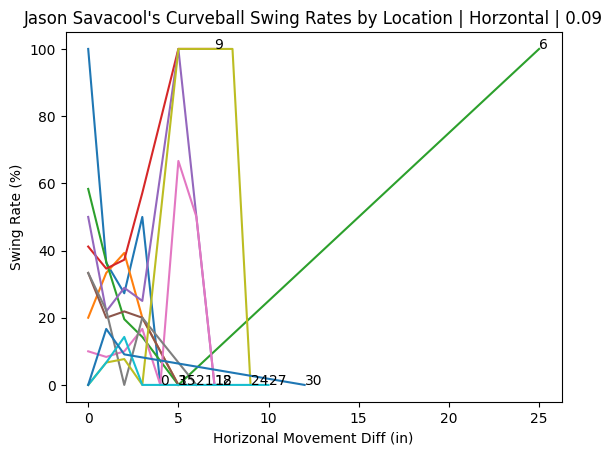

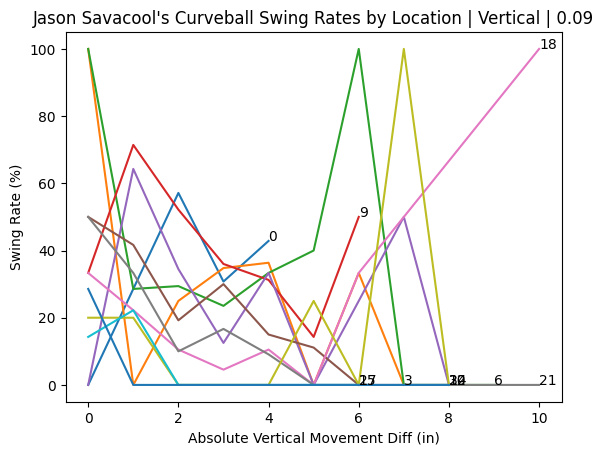

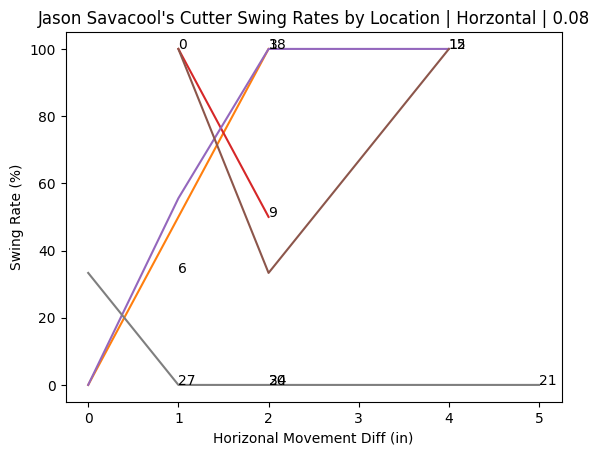

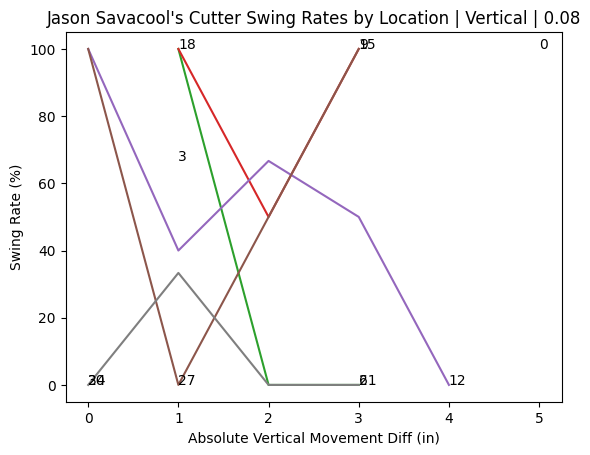

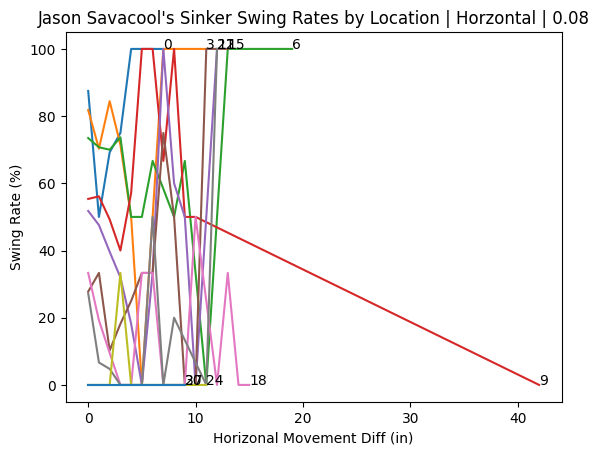

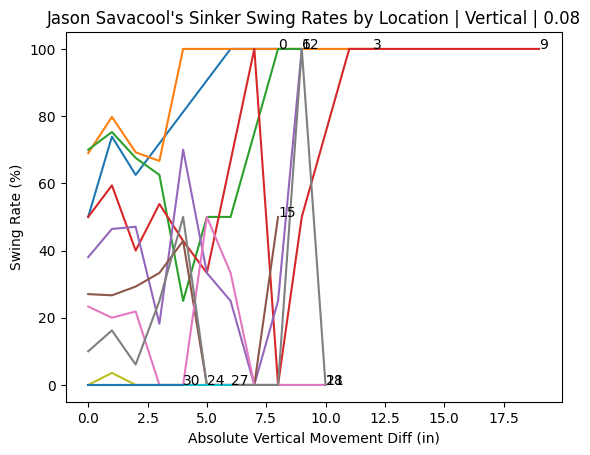

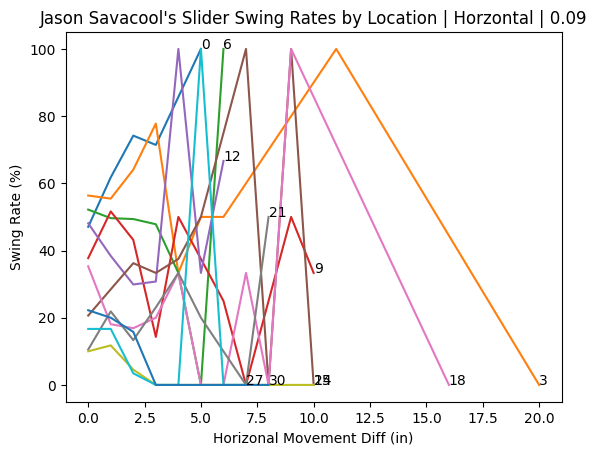

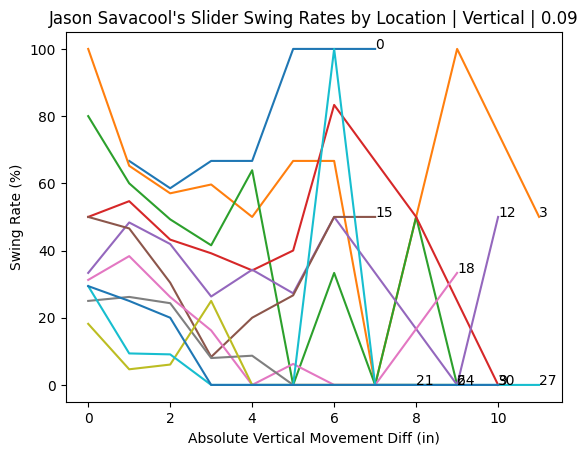

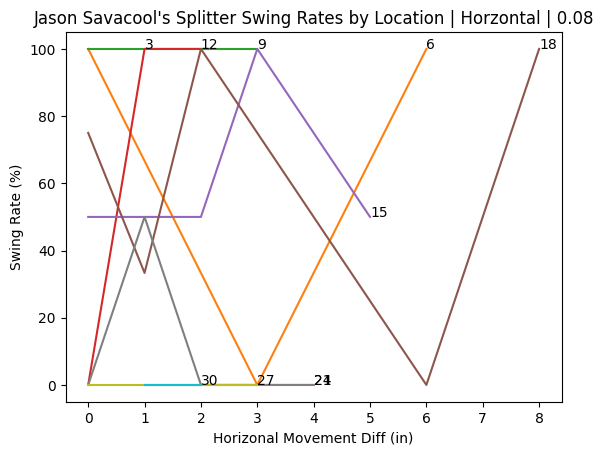

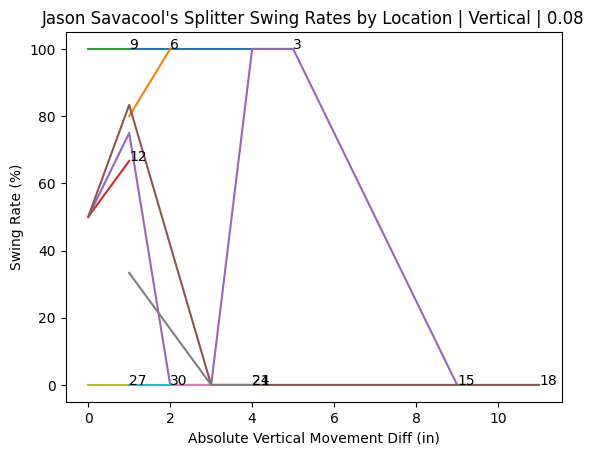

In [32]:
# baseline is the movement of four-seam
fsHorzMvmnt = df2.loc[df2['TaggedPitchType'] == 'Four-Seam']['horzDiff0'].mean()
fsVertMvmnt = df2.loc[df2['TaggedPitchType'] == 'Four-Seam']['vertDiff0'].mean()

# round the movement diffs at 50ft for plotting and find out how far from the average four-seam
df2['wholeHorzDiff0'] = round(abs(df2['horzDiff0']-fsHorzMvmnt))
df2['wholeVertDiff0'] = round(abs(df2['vertDiff0']-fsVertMvmnt))

# plot!
for k in pitch_data:
    if k != 'Four-Seam':
        # clear last pitch's graph
        plt.close()
        
        # set up next ptch horizonal break graph
        time = pitch_data[k][5]
        plt.title(f'{pitcher}\'s {k} Swing Rates by Location | Horzontal | {round(time, 2)}')
        plt.ylabel('Swing Rate (%)')
        plt.xlabel('Horizonal Movement Diff (in)')

        pitch_df = df2.loc[df2['TaggedPitchType'] == k]
        bucket_dfs = pitch_df.groupby('locBucket')
        for bucket in bucket_dfs:
            if bucket[0] <= 30:
                x_vals = []
                y_vals = []
                diff_dfs = bucket[1].groupby('wholeHorzDiff0')
                for diff in diff_dfs:
                    x_vals.append(diff[0])
                    y_vals.append(diff[1]['swing?'].mean() * 100)
                plt.plot(x_vals, y_vals, label= k)
                plt.text(x_vals[-1], y_vals[-1], bucket[0])
        
        plt.show()
        plt.close()
        
        # set up next ptch vertical break graph
        plt.title(f'{pitcher}\'s {k} Swing Rates by Location | Vertical | {round(time, 2)}')
        plt.ylabel('Swing Rate (%)')
        plt.xlabel('Absolute Vertical Movement Diff (in)')

        pitch_df = df2.loc[df2['TaggedPitchType'] == k]
        bucket_dfs = pitch_df.groupby('locBucket')
        for bucket in bucket_dfs:
            if bucket[0] <= 30:
                x_vals = []
                y_vals = []
                diff_dfs = bucket[1].groupby('wholeVertDiff0')
                for diff in diff_dfs:
                    x_vals.append(diff[0])
                    y_vals.append(diff[1]['swing?'].mean() * 100)
                plt.plot(x_vals, y_vals, label= k)
                plt.text(x_vals[-1], y_vals[-1], bucket[0])
        plt.show()
